In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.11.0


# Экономичность топлива

[Источник данных](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

В этом ноутбуке используется классический Auto MPG Dataset и строится модель для прогнозирования экономичности топлива автомобилей конца 1970-х - начала 1980-х годов. Для этого мы предоставим модели описание многих автомобилей того времени. Это описание включает такие атрибуты, как: цилиндры, рабочий объем, мощность и вес.

## Подготовка данных

### Загрузка

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [3]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Очистка

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

Исходя из описания колонки происхождения (origin) переведем числа в название страны и конвертируем в one-hot формат:

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Подготовка обучающей и тестовой выборки

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Взгляните на совместное распределение нескольких пар столбцов из обучающей выборки.

Глядя на верхний ряд становится понятно, что эффективность топлива (MPG) является функцией всех других параметров. Глядя на другие строки становится понятно, что каждая из них является функцией друг друга.

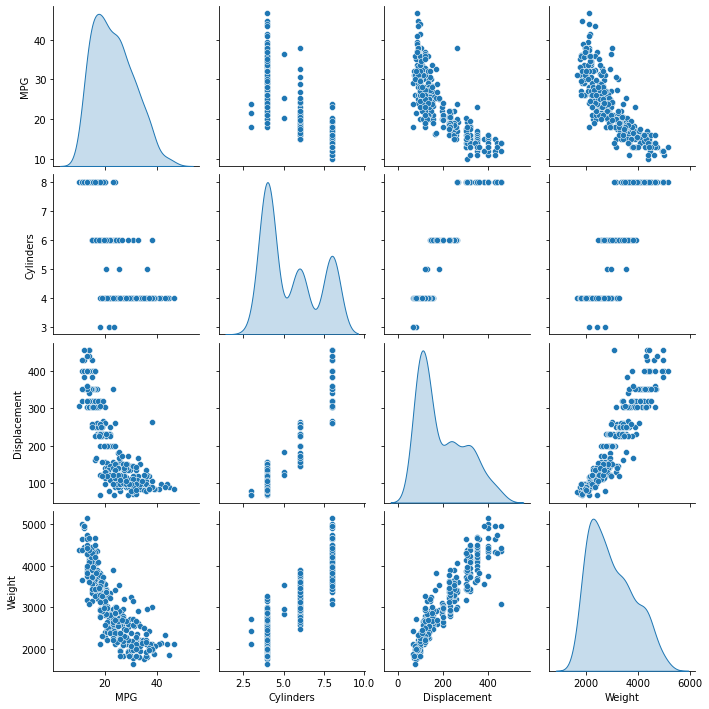

In [8]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Каждая функция охватывает очень разный диапазон:

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


Выделим целевой признак и уберем его из данных:

In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Нормализация

Одна из причин, по которой важно нормализовывать данные заключается в том, что характеристики умножаются на веса модели. Таким образом, масштаб выходных данных и масштаб градиентов зависит от масштаба входных данных.

Хотя модель может сходиться без нормализации функций, нормализация делает обучение более стабильным.

Слой preprocessing.Normalization - чистый и простой способ встроить эту предварительную обработку в вашу модель.

Первым делом создадим слой:

In [11]:
normalizer = preprocessing.Normalization()

Затем адаптируем .adapt() его к данным:

In [12]:
normalizer.adapt(np.array(train_features))

In [13]:
normalizer.mean.numpy()

array([5.4777069e+00, 1.9531847e+02, 1.0486943e+02, 2.9902517e+03,
       1.5559236e+01, 7.5898087e+01, 1.5732484e+00], dtype=float32)

Когда слой вызывается, он возвращает входные данные, при этом каждая функция нормализуется независимо:

In [14]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.72]]


## Линейная регрессия [1 предикат]

Начнем с линейной регрессии с одной переменной, чтобы спрогнозировать MPG из Horsepower .

Обучение модели с tf.keras обычно начинается с определения архитектуры модели. В этом случае используйте модель keras.Sequential . Эта модель представляет собой последовательность шагов обработки. В этом случае есть два шага:

* Нормализовать входную horsepower .
* Примените линейное преобразование ($y = mx+b$), чтобы получить 1 результат с использованием layers.Dense .
Количество входов может быть установлено аргументом input_shape или автоматически при первом запуске модели.

Сначала создайте слой Normalization лошадиных сил:

In [15]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

Строим последовательную модель:

In [16]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary() # сводка по модели - каждый слой и его кол-во праметров

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Эта модель будет прогнозировать MPG от Horsepower.

Запустим неподготовленную модель на первых 10 значениях мощности. Результат не будет хорошим, но можно видеть, что он имеет ожидаемую форму (10,1):

In [17]:
horsepower_model.predict(horsepower[:10])

array([[-1.240345  ],
       [-0.70051265],
       [ 2.289328  ],
       [-1.7386516 ],
       [-1.5725495 ],
       [-0.61746144],
       [-1.8632284 ],
       [-1.5725495 ],
       [-0.40983367],
       [-0.70051265]], dtype=float32)

После построения модели настройте процедуру обучения с помощью Model.compile() . Наиболее важные аргументы для компиляции - это loss и optimizer поскольку они определяют, что будет оптимизировано ( mean_absolute_error ) и как (с помощью optimizers.Adam ).

In [18]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

После настройки обучения используйте Model.fit() для выполнения обучения:

In [19]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # не отображаем ход обучения
    verbose=0,
    # Валидационная выборка - 20%
    validation_split = 0.2)

CPU times: user 6.69 s, sys: 369 ms, total: 7.06 s
Wall time: 6.5 s


Визуализируем прогресс обучения модели, используя статистику, хранящуюся в объекте history:

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803142,4.176042,95
96,3.803760,4.182850,96
97,3.804418,4.189486,97
98,3.802113,4.194804,98
99,3.803419,4.214349,99


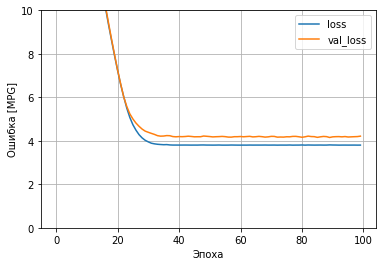

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)    

Смотрим на результаты на тестовом наборе:

In [22]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0)

In [23]:
test_results

{'horsepower_model': 3.651719331741333}

Так как это регрессия с одной переменной, легко рассматривать прогнозы модели как функцию входных данных:

In [24]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

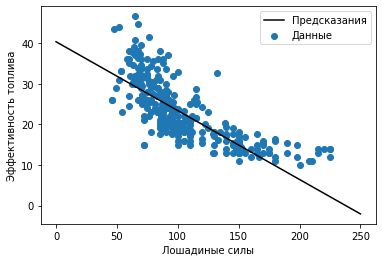

In [25]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Данные')
    plt.plot(x, y, color='k', label='Предсказания')
    plt.xlabel('Лошадиные силы')
    plt.ylabel('Эффективность топлива')
    plt.legend()

plot_horsepower(x,y)

In [26]:
test_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
9,8,390.0,190.0,3850.0,8.5,70,1
25,8,360.0,215.0,4615.0,14.0,70,1
28,8,304.0,193.0,4732.0,18.5,70,1
31,4,113.0,95.0,2228.0,14.0,71,3
33,6,232.0,100.0,2634.0,13.0,71,1
...,...,...,...,...,...,...,...
369,4,112.0,88.0,2395.0,18.0,82,1
375,4,105.0,74.0,1980.0,15.3,82,2
382,4,108.0,70.0,2245.0,16.9,82,3
384,4,91.0,67.0,1965.0,15.7,82,3


In [30]:
from sklearn.metrics import r2_score

preds = horsepower_model.predict(test_features['Horsepower']).flatten()
print(preds.shape)

print(test_labels.shape)

real = test_labels.values

r2_score(real, preds)

(78,)
(78,)


0.6679418757328923

## Линейная регрессия [все предикаты]

Вы можете использовать почти идентичную настройку, чтобы делать прогнозы на основе нескольких входных данных. Эта модель по-прежнему делает то же самое $y = mx +b$, за исключением того, что $m$ - это матрица, а $b$ - вектор.

На этот раз используем слой Normalization который был адаптирован для всего набора данных.

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

Когда вы вызываете эту модель для пакета входных данных, она выдает units=1 выходных данных для каждого примера.

In [32]:
linear_model.predict(train_features[:10])

array([[-0.95853686],
       [-1.4994028 ],
       [ 0.8806313 ],
       [-1.6201367 ],
       [ 0.20422208],
       [-0.46411446],
       [ 0.23424053],
       [-0.92164147],
       [-0.16306761],
       [ 0.7973094 ]], dtype=float32)

При вызове модели будут построены весовые матрицы. Теперь вы можете видеть, что kernel ($m$ в $y=mx+b$) имеет форму (9,1) .

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[ 0.7102118 ],
       [ 0.26371926],
       [ 0.10783815],
       [-0.32464057],
       [ 0.00668281],
       [-0.305525  ],
       [ 0.6663801 ]], dtype=float32)>

Используйте те же вызовы compile и fit что и для модели horsepower с одним входом:

In [35]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [36]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # не отображаем процесс обучения
    verbose=0,
    # валидация по 20%
    validation_split = 0.2)

CPU times: user 6.84 s, sys: 302 ms, total: 7.14 s
Wall time: 6.35 s


Использование всех входных данных позволяет получить гораздо меньшую ошибку обучения и проверки, чем модель horsepower :

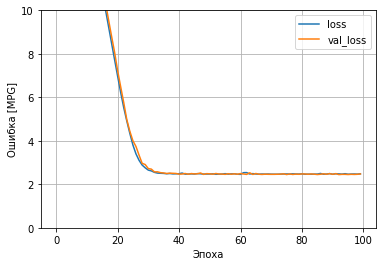

In [37]:
plot_loss(history)

Смотрим на результаты на тестовом наборе:

In [38]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [39]:
test_results

{'horsepower_model': 3.651719331741333, 'linear_model': 2.493820905685425}

In [40]:
preds = linear_model.predict(test_features).flatten()
print(preds.shape)

print(test_labels.shape)

r2_score(real, preds)

(78,)
(78,)


0.8097411234100289

## Регрессия DNN

В предыдущем разделе реализованы линейные модели для одного и нескольких входов.

В этом разделе реализуются модели DNN с одним и несколькими входами. Код в основном тот же, за исключением того, что модель расширена за счет включения некоторых «скрытых» нелинейных слоев. Название «скрытый» здесь просто означает «не подключен напрямую к входам или выходам».

Эти модели будут содержать на несколько слоев больше, чем линейная модель:

* Слой нормализации.
* Два скрытых, нелинейных, Dense слоя, использующих нелинейность relu .
* Линейный одинарный выходной слой.

Оба будут использовать одну и ту же процедуру обучения, поэтому метод compile включен в функцию build_and_compile_model ниже.

In [41]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                    optimizer=tf.keras.optimizers.Adam(0.001))
    return model

### Одна переменная

Начнем с модели DNN для одного входа: «Лошадиная сила».

In [53]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

Эта модель имеет намного больше обучаемых параметров, чем линейные модели.

In [54]:
dnn_horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Обучим модель:

In [55]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 14.5 s, sys: 617 ms, total: 15.1 s
Wall time: 13.5 s


Модель справляется лучше простой линейной:

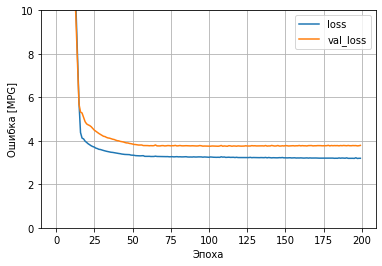

In [56]:
plot_loss(history)

Если вы построите прогноз как функцию Horsepower , вы увидите, как эта модель использует преимущества нелинейности, обеспечиваемой скрытыми слоями:

In [57]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

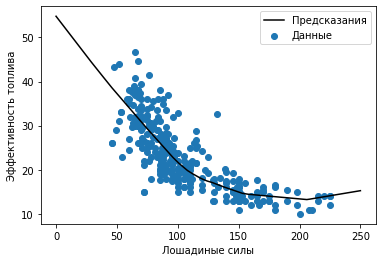

In [58]:
plot_horsepower(x, y)

Посмотрим на результаты на тестовой выборке:

In [59]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [60]:
test_results

{'dnn_horsepower_model': 2.8102636337280273,
 'horsepower_model': 3.651719331741333,
 'linear_model': 2.493820905685425}

In [61]:
preds = dnn_horsepower_model.predict(test_features['Horsepower']).flatten()
print(preds.shape)

print(test_labels.shape)

r2_score(real, preds)

(78,)
(78,)


0.8091671810838075

### Все данные

Если вы повторите этот процесс, используя все входные данные, это немного повысит производительность набора данных проверки.

In [65]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense_11 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________


In [66]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=250)

CPU times: user 18.8 s, sys: 759 ms, total: 19.6 s
Wall time: 17.5 s


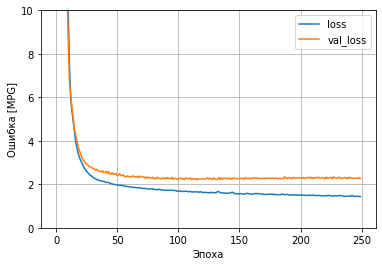

In [67]:
plot_loss(history)

In [68]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [69]:
test_results

{'dnn_horsepower_model': 2.8102636337280273,
 'dnn_model': 1.8650665283203125,
 'horsepower_model': 3.651719331741333,
 'linear_model': 2.493820905685425}

In [70]:
preds = dnn_model.predict(test_features).flatten()
print(preds.shape)

print(test_labels.shape)

r2_score(real, preds)

(78,)
(78,)


0.8994211773444549

In [71]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651719
linear_model,2.493821
dnn_horsepower_model,2.810264
dnn_model,1.865067


## Предсказания

Посмотрим визуально на ошибки, сделанные моделью при прогнозировании на тестовом наборе:

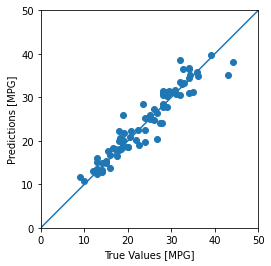

In [72]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Похоже, модель достаточно хорошо предсказывает.

Теперь посмотрим на распределение ошибок:

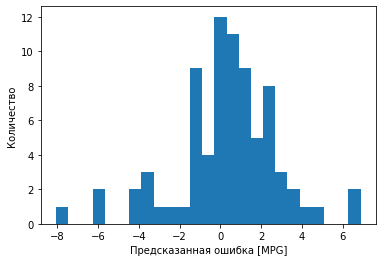

In [73]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Предсказанная ошибка [MPG]')
_ = plt.ylabel('Количество')

Если модель вас устраивает, сохраните ее для дальнейшего использования:

In [74]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


Если вы перезагрузите модель, она выдаст идентичный результат:

In [75]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [76]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651719
linear_model,2.493821
dnn_horsepower_model,2.810264
dnn_model,1.865067
reloaded,1.865067


# Fashion MNIST - тюнинг параметров

Keras Tuner - это библиотека, которая помогает вам выбрать оптимальный набор гиперпараметров для вашей модели. Процесс выбора правильного набора гиперпараметров для вашего приложения машинного обучения (ML) называется настройкой гиперпараметров или файн-тюнинг.

Гиперпараметры - это переменные, которые управляют процессом обучения и топологией модели машинного обучения. Эти переменные остаются постоянными в процессе обучения и напрямую влияют на производительность вашей программы машинного обучения. Гиперпараметры бывают двух типов:

Гиперпараметры модели, влияющие на выбор модели, такие как количество и ширина скрытых слоев.

Гиперпараметры алгоритма, которые влияют на скорость и качество алгоритма обучения, такие как скорость обучения для стохастического градиентного спуска (SGD) и количество ближайших соседей для классификатора k ближайших соседей (KNN)

В этом руководстве вы будете использовать Keras Tuner для выполнения гипертонастройки для приложения классификации изображений.

In [77]:
import tensorflow as tf
from tensorflow import keras

import IPython

In [78]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 7.3MB/s 


## Подготовка данных

[Источник данных](https://github.com/zalandoresearch/fashion-mnist)

Представляет из себя набор данных об одежде с метками

Label	| Description
-|-
 0	| T-shirt/top
1	| Trouser
2	| Pullover
3	|Dress
4	| Coat
5	|Sandal
6	|Shirt
7	|Sneaker
8	|Bag
9	|Ankle boot

In [79]:
fash_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [80]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Нормализуем данные. Поскольку все данные находятся в диапазоне от 0 до 255 (яркости пикселей) - просто разделим их на 255

In [81]:
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

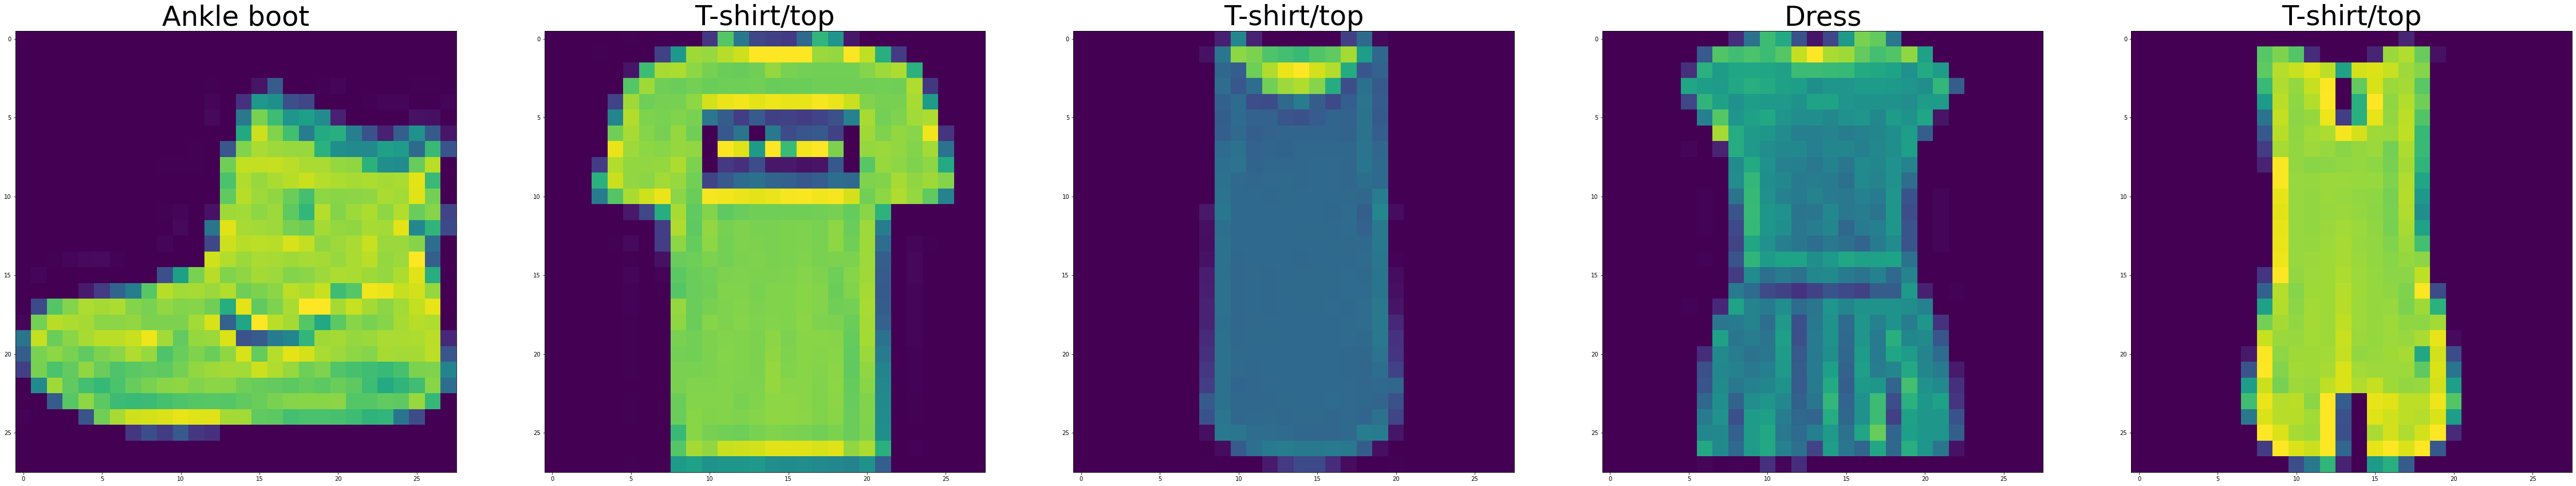

In [82]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(img_train[i].reshape(28, 28))
    ax[i].set_title(fash_labels[label_train[i]], fontdict = {'fontsize':48})
plt.show()

### Модель

Когда вы строите модель для гипертонастройки, вы также определяете пространство поиска гиперпараметров в дополнение к архитектуре модели. Модель, которую вы настроили для гипертюнинга, называется гипермоделью .

Вы можете определить гипермодель двумя способами:

* Используя функцию построителя модели
* HyperModel подкласс класса HyperModel API Keras Tuner

Вы также можете использовать два предопределенных класса HyperModel - HyperXception и HyperResNet для приложений компьютерного зрения.

В этом руководстве вы используете функцию построителя моделей для определения модели классификации изображений. Функция построителя моделей возвращает скомпилированную модель и использует гиперпараметры, которые вы определяете встроенными, для гипертонастройки модели.

In [86]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Настраиваем кол-во нейронов в первом слое полносвязной сети в диапазоне 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(keras.layers.Dense(10))

    # Настраиваем оптимальную скорость обучения, скорости 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                    metrics = ['accuracy'])

    return model

Создадим экземпляр тюнера и выполним файн-тюнинг

Создайте экземпляр тюнера для выполнения файнтюнинга. У Keras Tuner есть четыре доступных тюнера - RandomSearch , Hyperband , BayesianOptimization и Sklearn . В этом руководстве вы используете тюнер Hyperband .

Чтобы создать экземпляр тюнера Hyperband, вы должны указать гипермодель, objective для оптимизации и максимальное количество эпох для обучения ( max_epochs ).

In [87]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

Алгоритм настройки Hyperband использует адаптивное распределение ресурсов и раннюю остановку, чтобы быстро перейти к высокопроизводительной модели. Алгоритм обучает большое количество моделей в течение нескольких эпох и переносит на следующий этап только половину наиболее эффективных моделей. Hyperband определяет количество моделей для обучения в группе, вычисляя factor логарифма 1 + ( max_epochs ) и округляя его до ближайшего целого числа.

Перед запуском поиска по гиперпараметрам определите обратный вызов для очистки результатов обучения в конце каждого шага обучения.

In [88]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

Запустите поиск гиперпараметров. Аргументы для метода поиска те же, что и для tf.keras.model.fit в дополнение к tf.keras.model.fit вызову выше.

In [89]:
with tf.device('/gpu:0'):
    tuner.search(img_train,
                label_train,
                epochs = 10,
                validation_data = (img_test, label_test),
                callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.871399998664856

Best val_accuracy So Far: 0.8888000249862671
Total elapsed time: 00h 07m 50s
INFO:tensorflow:Oracle triggered exit


Переобучим модель с оптимальными гиперпараметрами из поиска:

In [90]:
with tf.device('/gpu:0'):
    model = tuner.hypermodel.build(best_hps)
    model.fit(img_train,
            label_train,
            epochs = 10,
            validation_data = (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6128 - accuracy: 0.7882 - val_loss: 0.4315 - val_accuracy: 0.8456
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3700 - accuracy: 0.8664 - val_loss: 0.3900 - val_accuracy: 0.8592
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3319 - accuracy: 0.8789 - val_loss: 0.3707 - val_accuracy: 0.8671
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3041 - accuracy: 0.8864 - val_loss: 0.3566 - val_accuracy: 0.8748
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2897 - accuracy: 0.8936 - val_loss: 0.3719 - val_accuracy: 0.8669
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2750 - accuracy: 0.8971 - val_loss: 0.3915 - val_accuracy: 0.8641
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2606 - accuracy: 0.9020 - val_loss: 0.3350 - val_accuracy:

my_dir/intro_to_kt содержит подробные журналы и контрольные точки для каждого испытания (конфигурации модели), запущенного во время поиска гиперпараметров. Если вы повторно запустите поиск гиперпараметров, Keras Tuner использует существующее состояние из этих журналов для возобновления поиска. Чтобы отключить это поведение, передайте дополнительный аргумент overwrite = True при создании экземпляра тюнера.

In [91]:
preds = model.predict(img_test)

In [92]:
preds.shape

(10000, 10)

In [93]:
preds

array([[-1.11039000e+01, -1.72830334e+01, -1.39126444e+01, ...,
         1.00939023e+00, -1.15793152e+01,  6.36905718e+00],
       [-1.46989562e-02, -2.08406601e+01,  9.34345150e+00, ...,
        -1.45314245e+01, -7.98101568e+00, -2.34065552e+01],
       [-4.55226517e+00,  1.56036339e+01, -1.46762705e+01, ...,
        -5.09171562e+01, -1.65151711e+01, -3.77180786e+01],
       ...,
       [-4.24315548e+00, -1.73098125e+01, -6.56218767e+00, ...,
        -1.07644768e+01,  5.40962887e+00, -2.24602375e+01],
       [-8.81434631e+00,  1.23252144e+01, -1.18557863e+01, ...,
        -3.55060577e+01, -1.06769104e+01, -2.68231907e+01],
       [-6.76780701e+00, -1.51413603e+01, -9.26979256e+00, ...,
        -1.52063179e+00, -4.15773439e+00, -6.56853628e+00]], dtype=float32)

In [94]:
y_classes = preds.argmax(axis=-1)
y_classes[:5]

array([9, 2, 1, 1, 6])

In [95]:
label_test

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [96]:
from sklearn.metrics import classification_report

print(classification_report(label_test, y_classes, target_names = list(fash_labels.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.84      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.84      0.75      0.79      1000
       Dress       0.85      0.93      0.89      1000
        Coat       0.80      0.78      0.79      1000
      Sandal       0.98      0.95      0.97      1000
       Shirt       0.69      0.73      0.71      1000
     Sneaker       0.92      0.98      0.95      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

